<a href="https://colab.research.google.com/github/julialromero/Collaborative-Problem-Solving/blob/main/learning_pipeline_angelina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/julialromero/Collaborative-Problem-Solving/blob/main/learning_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import os
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras import layers, Input, Model, optimizers
from keras.applications.inception_v3 import InceptionV3


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

PROJECT_DIR = "drive/MyDrive/CSCI 5922 - Final Project/"

Wed Apr 27 07:02:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    40W / 250W |   8765MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get User Input

In [ ]:
# Choose what size images to use
## "small" = 98x98, "med" = 332x332, "large" = 719x719
image_size = "med"
shuffled = False

if image_size == "large":
  imgsize = (int(719/2), int(719/2)) 
  if shuffled:
    IMG_DIR = "719x719 - Recurrence_Matrices/RAW_SHUFFLED/"
  else:
    IMG_DIR = "719x719 - Recurrence_Matrices/RAW/"

elif image_size == "med":
  imgsize = (332, 332)
  if shuffled:
    IMG_DIR = "332x332 - Recurrence_Matrices/RAW_SHUFFLED/"
  else:
    IMG_DIR = "332x332 - Recurrence_Matrices/RAW/"

elif image_size == "small":
  imgsize = (98, 98)
  if shuffled:
    IMG_DIR = "98x98 - Recurrence_Matrices/RAW_SHUFFLED/"
  else:
    IMG_DIR = "98x98 - Recurrence_Matrices/RAW/"

print("Processing images from: ", IMG_DIR)

Processing images from:  332x332 - Recurrence_Matrices/RAW/


# Scratchwork

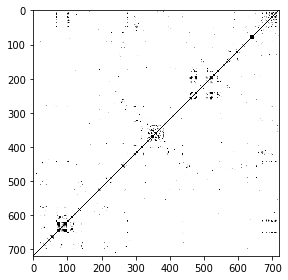

In [ ]:
from skimage import io
imag = io.imread(PROJECT_DIR + IMG_DIR + '1010-ExpBlock1_RAW.png', as_gray=True)
io.imshow(imag)

In [ ]:
for filename in os.listdir(PROJECT_DIR + IMG_DIR)[0:15]:
    imag = io.imread(PROJECT_DIR + IMG_DIR + filename, as_gray=True)
    print(imag.shape)

(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)


(719, 719, 3)


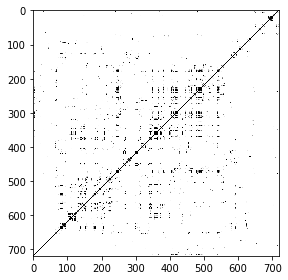

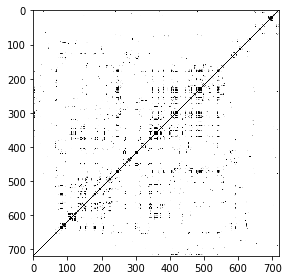

In [ ]:

imag = io.imread(PROJECT_DIR + IMG_DIR + '1020-ExpBlock1_RAW.png', as_gray=True)
plt.figure()
io.imshow(imag)

x = image.img_to_array(imag)
# x = tf.image.resize(x, imgsize) # TODO: try interpolation = "nearest" instead of default "bilinear"

x = np.squeeze(np.stack((x,)*3))
x = x.swapaxes(0,1)
x = x.swapaxes(1,2)
print(x.shape)
plt.figure()
io.imshow(x)



x shape:  (719, 719, 1)


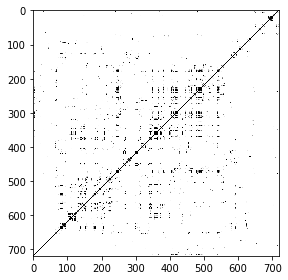

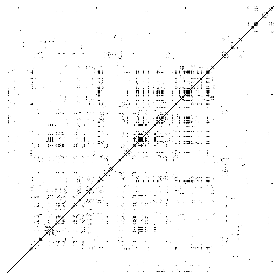

In [ ]:

x = tf.image.resize(x, imgsize) # TODO: try interpolation = "nearest" instead of default "bilinear"

#x = tf.keras.preprocessing.image.smart_resize(x, imgsize)
x = np.array(x)
plt.figure()
plt.axis('off')
io.imshow(x.squeeze())
#n = preprocess_input(x)    # preprocess input for Inception v3
print("x shape: ", x.shape)

# Helper Functions

---NOTE---
Resizing the image changes the RP so for now keep it the same size.

In [ ]:
# read, preprocess, and scale images to uniform dimension

def extract_image(image_path):
    imag = io.imread(image_path, as_gray=True)
    x = image.img_to_array(imag)

    x = tf.image.resize(x, imgsize) # TODO: try interpolation = "nearest" instead of default "bilinear"

    return x

def extract_image_inceptionv3(image_path):
    imag = io.imread(image_path, as_gray=True)
    x = image.img_to_array(imag)

    x = tf.image.resize(x, imgsize) # TODO: try interpolation = "nearest" instead of default "bilinear"
    x = np.squeeze(np.stack((x,)*3))
    x = x.swapaxes(0,1)
    x = x.swapaxes(1,2)

    return x





In [ ]:
def accuracy(predicted, observed):
    if(len(predicted) != len(observed)):
        print("Error - length of input series is not equal.")
        return np.nan
    
    correct = 0
    for pred, obs in zip(predicted, observed):
        if pred == obs:
            correct += 1
    acc = correct / len(predicted)
    return acc

In [ ]:
def extract_score(filename, outcome_df, score_col="task_score"):
    #  match this file's id/block with task score and return
    groupid, splitname = filename.split("-")
    block = splitname.split("_")[0]
    row = outcome_df.loc[(outcome_df.GROUPID == int(groupid)) & (outcome_df.block == block)]
    if(row.shape[0] != 1):
        print(f"Error -- Number of task scores recorded is not 1 for block {block} and groupid {groupid}.")
        return np.nan
    score = row[score_col].values[0]
    return score

In [ ]:
def extract_binary_score(filename, outcome_df, score_col="task_score", median_score=2):
    #  match this file's id/block with task score and return
    groupid, splitname = filename.split("-")
    block = splitname.split("_")[0]
    row = outcome_df.loc[(outcome_df.GROUPID == int(groupid)) & (outcome_df.block == block)]
    if(row.shape[0] != 1):
        print(f"Error -- Number of task scores recorded is not 1 for block {block} and groupid {groupid}.")
        return np.nan
    raw_score = row[score_col].values[0]
    if raw_score <= median_score:
        score = 0
    else:
        score = 1
    return score

# Load and preprocess data

In [ ]:
outcome_df = pd.read_csv(PROJECT_DIR + "team_block_outcomes.csv")

# get median task_score
task_scores = outcome_df["task_score"]
median_task_score = np.median(task_scores)
mean_task_score = np.mean(task_scores)
print("median: ", median_task_score)
print("mean: ", mean_task_score)

# score_counts = dict(Counter(task_scores))
# for key in score_counts:
#     print("%d: %d" % (key, score_counts[key]))

median:  2.0
mean:  3.5437956204379564


In [ ]:
# read data to np arrays
recurrence_plot_list = []
recurrence_plot_list_incv3 = []
labels = []
binary_labels = []

for filename in os.listdir(PROJECT_DIR + IMG_DIR):
    # preprocess image
    t = extract_image(PROJECT_DIR + IMG_DIR + filename)
    t_incv3 = extract_image_inceptionv3(PROJECT_DIR + IMG_DIR + filename)

    # get task score
    lab = extract_score(filename, outcome_df, score_col="task_score")
    bin_lab = extract_binary_score(filename, outcome_df, score_col="task_score", median_score=2)

    # append data
    recurrence_plot_list.append(t)
    recurrence_plot_list_incv3.append(t_incv3)
    labels.append(lab)
    binary_labels.append(bin_lab)
    

recurrence_plot_list = np.array(recurrence_plot_list)
recurrence_plot_list_incv3 = np.array(recurrence_plot_list_incv3)
labels = np.array(labels)
binary_labels = np.array(binary_labels)

print(f"recurrence_plot_list: {recurrence_plot_list.shape}")
print(f"recurrence_plot_list_incv3: {recurrence_plot_list_incv3.shape}")
binary_counts = dict(Counter(binary_labels))
print("Binary label counts: ", binary_counts)

print("Continous label ex: ", labels[4])
print("Binary label ex: ", binary_labels[4])


recurrence_plot_list: (271, 332, 332, 1)
recurrence_plot_list_incv3: (271, 332, 332, 3)
Binary label counts:  {1: 132, 0: 139}
Continous label ex:  8.0
Binary label ex:  1


In [ ]:
if (recurrence_plot_list.shape[0] == len(np.unique(recurrence_plot_list, axis=0))):
    print("No duplicate samples.")
else:
    print("WARNING - duplicate samples.")
    

No duplicate samples.


# Binary Classification.
Output layer has 1 node with sigmoid activation.
y labels are 0 or 1


## Model from scratch

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

# Split into train/test/val set
# Roughly val - 15%, test - 15%, train - 70%
X_train, X_test, y_train, y_test = train_test_split(recurrence_plot_list, binary_labels, train_size=0.88)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("\n")
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("\n")
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("\n")

print(y_test)

X_train:  (202, 332, 332, 1)
y_train:  (202,)


X_val:  (36, 332, 332, 1)
y_val:  (36,)


X_test:  (33, 332, 332, 1)
y_test:  (33,)


[1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0]


In [ ]:
# Garcia-Ceja paper feeds CNN images with dims 100 x 100 x 4 (width x height x channels)
# Labels are one hot encoded

inputs = Input(shape=(imgsize[0], imgsize[1], 1))
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(512, activation="relu")(x) 
x = layers.Dropout(0.50)(x)
x = layers.Flatten()(x)
out = layers.Dense(1, activation="sigmoid")(x)   # change output layer to 1 and activation to sigmoid


bc = tf.keras.losses.BinaryCrossentropy()        # change loss to binary
lr = 0.00001 # paper used 0.001
eps = 1e-08  # paper used 1e-08, but keras default is 1e-07
adam = keras.optimizers.Adam(learning_rate=lr, epsilon=eps)
auc = tf.keras.metrics.AUC(
      num_thresholds=200,
      curve="ROC",
      from_logits=False
)
prec = tf.keras.metrics.Precision()
rec = tf.keras.metrics.Recall()


model_binary = Model(inputs=inputs, outputs=out)
model_binary.compile(
  optimizer=adam,
  loss=bc, 
  metrics=['accuracy', auc, prec, rec],
)

model_binary.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 332, 332, 1)]     0         
                                                                 
 conv2d_1184 (Conv2D)        (None, 330, 330, 16)      160       
                                                                 
 conv2d_1185 (Conv2D)        (None, 328, 328, 16)      2320      
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 164, 164, 16)     0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 164, 164, 16)      0         
                                                                 
 conv2d_1186 (Conv2D)        (None, 162, 162, 32)      4640      
                                                          

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# es = EarlyStopping(monitor='val_loss', patience=15)

if shuffled:
  MODEL_SAVE_DIR = PROJECT_DIR + 'results/shuffled/' + '.' + image_size + '_binary_best_weights.hdf5'
else:
  MODEL_SAVE_DIR = PROJECT_DIR + 'results/' + '.' + image_size + '_70a_binary_best_weights.hdf5'

print("Saving model to: ", MODEL_SAVE_DIR)

mcp_save = ModelCheckpoint(MODEL_SAVE_DIR, save_best_only=True, monitor='val_loss', mode='min')

info2 = model_binary.fit(x=X_train, y=y_train, epochs=70, verbose=True, validation_data=(X_val, y_val), \
                         callbacks=[mcp_save])


Saving model to:  drive/MyDrive/CSCI 5922 - Final Project/results/.med_70a_binary_best_weights.hdf5
Epoch 1/70
7/7 [==============================] - 6s 354ms/step - loss: 0.6990 - accuracy: 0.5446 - auc_26: 0.5159 - precision_26: 0.5455 - recall_26: 0.2500 - val_loss: 0.7189 - val_accuracy: 0.4722 - val_auc_26: 0.3963 - val_precision_26: 0.4722 - val_recall_26: 1.0000
Epoch 2/70
7/7 [==============================] - 1s 155ms/step - loss: 0.7182 - accuracy: 0.4752 - auc_26: 0.5187 - precision_26: 0.4648 - recall_26: 0.6875 - val_loss: 0.6950 - val_accuracy: 0.5278 - val_auc_26: 0.5681 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00
Epoch 3/70
7/7 [==============================] - 1s 170ms/step - loss: 0.7041 - accuracy: 0.5297 - auc_26: 0.5071 - precision_26: 1.0000 - recall_26: 0.0104 - val_loss: 0.6932 - val_accuracy: 0.4444 - val_auc_26: 0.4706 - val_precision_26: 0.4444 - val_recall_26: 0.7059
Epoch 4/70
7/7 [==============================] - 1s 115ms/step - loss: 0.70

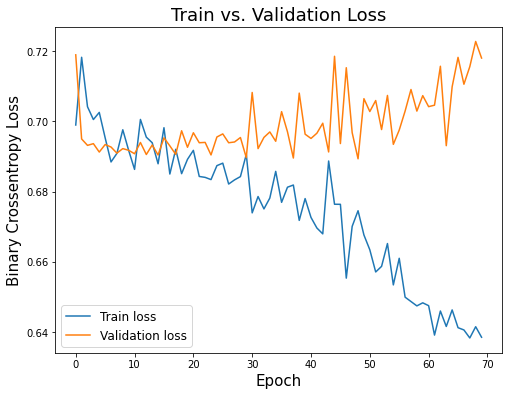

In [ ]:
epochs = [i for i in range(len(info2.history['accuracy']))]
plt.figure(figsize=(8,6))
plt.plot(epochs, info2.history['loss'], label="Train loss")
plt.plot(epochs, info2.history['val_loss'], label="Validation loss")
plt.legend(fontsize=12)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Binary Crossentropy Loss", fontsize=15)
plt.title("Train vs. Validation Loss", fontsize=18)

if shuffled:
  LOSS_SAVE_DIR = PROJECT_DIR + 'results/shuffled/' + image_size + '_binary_loss'
else:
  LOSS_SAVE_DIR = PROJECT_DIR + 'results/' + image_size + '_70a_binary_loss'

plt.savefig(LOSS_SAVE_DIR)

In [ ]:
train_scores = model_binary.evaluate(X_train, y_train, verbose = 0) 

print("===== Train Set Results =====\n")
for metric,val in zip(model_binary.metrics_names, train_scores):
  print("%12s: %.3f" % (metric, val))

===== Train Set Results =====

        loss: 0.632
    accuracy: 0.688
      auc_13: 0.803
precision_13: 0.770
   recall_13: 0.490


In [ ]:
val_scores = model_binary.evaluate(X_val, y_val, verbose = 0) 

print("===== Val Set Results =====\n")
for metric,val in zip(model_binary.metrics_names, val_scores):
  print("%12s: %.3f" % (metric, val))

===== Val Set Results =====

        loss: 0.636
    accuracy: 0.611
      auc_13: 0.781
precision_13: 0.556
   recall_13: 0.333


In [ ]:
test_scores = model_binary.evaluate(X_test, y_test, verbose = 0) 

print("===== Test Set Results =====\n")
for metric,val in zip(model_binary.metrics_names, test_scores):
  print("%12s: %.3f" % (metric, val))


===== Test Set Results =====

        loss: 0.683
    accuracy: 0.515
      auc_13: 0.710
precision_13: 0.727
   recall_13: 0.381


In [ ]:
from keras.models import load_model
fresh_model = load_model(MODEL_SAVE_DIR)

In [ ]:
train_scores = fresh_model.evaluate(X_train, y_train, verbose = 0) 

print("===== Train Set Results =====\n")
for metric,val in zip(fresh_model.metrics_names, train_scores):
  print("%12s: %.3f" % (metric, val))

===== Train Set Results =====

        loss: 0.668
    accuracy: 0.653
      auc_26: 0.800
precision_26: 0.587
   recall_26: 0.917


In [ ]:
val_scores = fresh_model.evaluate(X_val, y_val, verbose = 0) 

print("===== Val Set Results =====\n")
for metric,val in zip(fresh_model.metrics_names, val_scores):
  print("%12s: %.3f" % (metric, val))

===== Val Set Results =====

        loss: 0.689
    accuracy: 0.583
      auc_26: 0.624
precision_26: 0.538
   recall_26: 0.824


In [ ]:
test_scores = fresh_model.evaluate(X_test, y_test, verbose = 0) 

print("===== Test Set Results =====\n")
for metric,val in zip(fresh_model.metrics_names, test_scores):
  print("%12s: %.3f" % (metric, val))


===== Test Set Results =====

        loss: 0.667
    accuracy: 0.667
      auc_26: 0.818
precision_26: 0.682
   recall_26: 0.789


In [ ]:
y_pred = fresh_model.predict(X_test)

In [ ]:
for act,pred in zip(y_test, y_pred):
  print(act, pred)

0 [0.72380054]
0 [0.39113218]
1 [0.81299883]
0 [0.14974692]
1 [0.41391554]
0 [0.22371039]
1 [0.742237]
0 [0.7704877]
0 [0.19868647]
0 [0.42169863]
0 [0.24479426]
1 [0.4313374]
0 [0.49925306]
0 [0.2757193]
0 [0.9023791]
1 [0.4459089]
1 [0.16998664]
0 [0.05034836]
1 [0.23338144]
1 [0.6705797]
1 [0.81513643]
1 [0.9391132]
0 [0.19207337]
1 [0.19642119]
0 [0.48597834]
1 [0.900979]
0 [0.8093388]
1 [0.18469447]
0 [0.18706258]
0 [0.52050936]
0 [0.11997736]
0 [0.19096878]
0 [0.6665648]


## Pre-trained Inception v3

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

# Split into train/test/val set
# Roughly val - 15%, test - 15%, train - 70%
X_train, X_test, y_train, y_test = train_test_split(recurrence_plot_list_incv3, binary_labels, train_size=0.88)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.78)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("\n")
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("\n")
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("\n")

print(y_test)

X_train:  (185, 98, 98, 3)
y_train:  (185,)


X_val:  (53, 98, 98, 3)
y_val:  (53,)


X_test:  (33, 98, 98, 3)
y_test:  (33,)


[1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0]


In [ ]:
# Use InceptionV3 model for feature extraction
## Resource: http://marubon-ds.blogspot.com/2017/10/inceptionv3-fine-tuning-model.html

new_input = Input(shape=(imgsize[0], imgsize[1], 3)) # TODO

pretrained_model = tf.keras.applications.InceptionV3(
                   include_top=False,
                   weights="imagenet",
                   input_tensor=new_input
)

x = pretrained_model.output
x = layers.GlobalAveragePooling2D()(x)

out = layers.Dense(1, activation="sigmoid")(x) 


bc = tf.keras.losses.BinaryCrossentropy()        # change loss to binary
lr = 0.000001 # paper used 0.001
eps = 1e-08   # paper used 1e-08, but keras default is 1e-07
adam = keras.optimizers.Adam(learning_rate=lr, epsilon=eps)
auc = tf.keras.metrics.AUC(
      num_thresholds=200,
      curve="ROC",
      from_logits=False
)
prec = tf.keras.metrics.Precision()
rec = tf.keras.metrics.Recall()


model_pretrained = Model(inputs=new_input, outputs=out)
model_pretrained.compile(
  optimizer=adam,
  loss=bc, 
  metrics=['accuracy', auc, prec, rec],
)

model_pretrained.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 98, 98, 3)]  0           []                               
                                                                                                  
 conv2d_1090 (Conv2D)           (None, 48, 48, 32)   864         ['input_26[0][0]']               
                                                                                                  
 batch_normalization_1034 (Batc  (None, 48, 48, 32)  96          ['conv2d_1090[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_1034 (Activation)   (None, 48, 48, 32)   0           ['batch_normalization_1034

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# es = EarlyStopping(monitor='val_loss', patience=15)

if shuffled:
  MODEL_SAVE_DIR = PROJECT_DIR + 'results/shuffled/' + '.' + image_size + '_incv3_fine_tune_best_weights.hdf5'
else:
  MODEL_SAVE_DIR = PROJECT_DIR + 'results/' + '.' + image_size + '_70c_incv3_fine_tune_best_weights.hdf5'

print("Saving model to: ", MODEL_SAVE_DIR)

mcp_save = ModelCheckpoint(MODEL_SAVE_DIR, save_best_only=True, monitor='val_loss', mode='min')

info3 = model_pretrained.fit(x=X_train, y=y_train, epochs=70, verbose=True, validation_data=(X_val, y_val), \
                              callbacks=[mcp_save])


Saving model to:  drive/MyDrive/CSCI 5922 - Final Project/results/.small_70c_incv3_fine_tune_best_weights.hdf5
Epoch 1/70
6/6 [==============================] - 15s 952ms/step - loss: 0.7333 - accuracy: 0.4649 - auc_25: 0.4496 - precision_25: 0.4577 - recall_25: 0.7471 - val_loss: 0.6742 - val_accuracy: 0.6226 - val_auc_25: 0.6760 - val_precision_25: 0.6122 - val_recall_25: 0.9677
Epoch 2/70
6/6 [==============================] - 0s 83ms/step - loss: 0.7334 - accuracy: 0.4811 - auc_25: 0.4539 - precision_25: 0.4667 - recall_25: 0.7241 - val_loss: 0.7050 - val_accuracy: 0.5849 - val_auc_25: 0.5638 - val_precision_25: 0.5918 - val_recall_25: 0.9355
Epoch 3/70
6/6 [==============================] - 0s 84ms/step - loss: 0.7170 - accuracy: 0.5027 - auc_25: 0.4996 - precision_25: 0.4803 - recall_25: 0.7011 - val_loss: 0.7062 - val_accuracy: 0.5283 - val_auc_25: 0.5704 - val_precision_25: 0.5652 - val_recall_25: 0.8387
Epoch 4/70
6/6 [==============================] - 0s 84ms/step - loss: 0.7

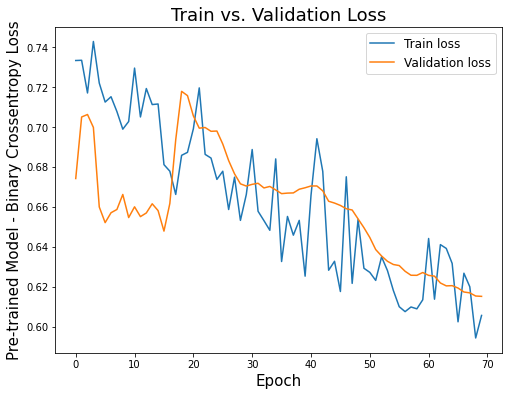

In [ ]:
epochs = [i for i in range(len(info3.history['accuracy']))]
plt.figure(figsize=(8,6))
plt.plot(epochs, info3.history['loss'], label="Train loss")
plt.plot(epochs, info3.history['val_loss'], label="Validation loss")
plt.legend(fontsize=12)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Pre-trained Model - Binary Crossentropy Loss", fontsize=15)
plt.title("Train vs. Validation Loss", fontsize=18)
plt.savefig(PROJECT_DIR + 'results/Pretrained_binary')

if shuffled:
  LOSS_SAVE_DIR = PROJECT_DIR + 'results/shuffled/' + image_size + '_incv3_fine_tune__loss'
else:
  LOSS_SAVE_DIR = PROJECT_DIR + 'results/' + image_size + '_70c_incv3_fine_tune__loss'

plt.savefig(LOSS_SAVE_DIR)


In [ ]:
from keras.models import load_model
fresh_model = load_model(MODEL_SAVE_DIR)

In [ ]:
train_scores = fresh_model.evaluate(X_train, y_train, verbose = 0) 

print("===== Train Set Results =====\n")
for metric,val in zip(fresh_model.metrics_names, train_scores):
  print("%12s: %.3f" % (metric, val))

===== Train Set Results =====

        loss: 0.560
    accuracy: 0.816
      auc_25: 0.918
precision_25: 0.798
   recall_25: 0.816


In [ ]:
val_scores = fresh_model.evaluate(X_val, y_val, verbose = 0) 

print("===== Val Set Results =====\n")
for metric,val in zip(fresh_model.metrics_names, val_scores):
  print("%12s: %.3f" % (metric, val))

===== Val Set Results =====

        loss: 0.615
    accuracy: 0.660
      auc_25: 0.699
precision_25: 0.697
   recall_25: 0.742


In [ ]:
test_scores = fresh_model.evaluate(X_test, y_test, verbose = 0) 

print("===== Test Set Results =====\n")
for metric,val in zip(fresh_model.metrics_names, test_scores):
  print("%12s: %.3f" % (metric, val))

===== Test Set Results =====

        loss: 0.704
    accuracy: 0.394
      auc_25: 0.477
precision_25: 0.333
   recall_25: 0.429


# Now lets try regression
Ideas -- <br>
1) Use tanh activation function (-1, 1). Scale labels to between -1, 1. One issue is that our data is [0, 15].
  - we could scale to (-0.99999, 0.999999). 
  - we could add labels for -1 and 16, then scale to betwen (-1, 1) then remove these fake labels.

<br>
2) sigmoid output ^ same but (0, 1)



In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

# Split into train/test/val set
# Roughly val - 15%, test - 15%, train - 70%
X_train, X_test, y_train, y_test = train_test_split(recurrence_plot_list, labels, train_size=0.88)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.78)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("\n")
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("\n")
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("\n")

print(y_test)

X_train:  (185, 359, 359, 1)
y_train:  (185,)


X_val:  (53, 359, 359, 1)
y_val:  (53,)


X_test:  (33, 359, 359, 1)
y_test:  (33,)


[ 6.  3.  6.  2.  7.  1.  4.  1.  5.  1.  1.  2.  3.  9.  6. 10.  0.  0.
  1. 11.  0.  1.  6.  1.  6.  3.  4.  2.  3.  2.  7.  4.  2.]


In [ ]:
# Garcia-Ceja paper feeds CNN images with dims 100 x 100 x 4 (width x height x channels)
# Labels are one hot encoded

inputs = Input(shape=(imgsize[0], imgsize[1], 1))
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(512, activation="relu")(x) 
x = layers.Dropout(0.50)(x)
x = layers.Flatten()(x)
out = layers.Dense(1, activation="linear")(x) 

regression_model = Model(inputs=inputs, outputs=out)
regression_model.compile(
  optimizer = "adam",
  loss= "mse", #tf.keras.losses.MeanSquaredError(),  
  metrics=['accuracy'],
)

regression_model.summary()

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#Scale y train data from [0, 15] to (-1, 1) for training the neural network

scaler = MinMaxScaler(feature_range=(-1, 1))
scale_data = np.array([i for i in range(-1, 17)]).reshape(-1, 1)
scaler.fit(scale_data)

y_train_scaled = scaler.transform(y_train.reshape(-1, 1))
y_val_scaled = scaler.transform(y_val.reshape(-1, 1)) 

# #scale to our target range [0, 15]
# scaled_predictions = scaler.inverse_transform(test_predictions) #/6 * 15

# # round to nearest int
# final_pred = np.array([round(i) for i in scaled_predictions])

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10)
mcp_save = ModelCheckpoint('drive/MyDrive/data/results/.regression_best_weights.hdf5', save_best_only=True, monitor='val_loss', mode='min')

info_regression = regression_model.fit(x=X_train, y=y_train, epochs=50, verbose=True, validation_data=(X_val, y_val), callbacks=[mcp_save])

In [ ]:
epochs = [i for i in range(len(info_regression.history['accuracy']))]
plt.figure(figsize=(8,6))
plt.plot(epochs, info_regression.history['loss'], label="Train loss")
plt.plot(epochs, info_regression.history['val_loss'], label="Validation loss")
plt.legend(fontsize=12)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("MSE Loss", fontsize=15)
plt.title("Loss for Tanh, 16 nodes in output", fontsize=18)
#plt.savefig('drive/MyDrive/data/results/Softmax_categorical')

In [ ]:
regression_model.load_weights(filepath = 'drive/MyDrive/data/results/.regression_best_weights.hdf5')

In [ ]:
# now calculate the actual accuracy
test_predictions = regression_model.predict(X_test)
train_predictions = regression_model.predict(X_train)
val_predictions = regression_model.predict(X_val)

In [ ]:
final_pred = enc.inverse_transform(test_predictions).squeeze()
final_train_pred = enc.inverse_transform(train_predictions).squeeze()
final_val_pred = enc.inverse_transform(val_predictions).squeeze()

In [ ]:
test_acc = accuracy(final_pred, y_test)
train_acc = accuracy(final_train_pred, y_train)
val_acc = accuracy(final_val_pred, y_val)
print("Classification with tanh")
print("----Results----")
print(f"Size of train set: {y_train.shape[0]}")
print(f"Train acc: {train_acc}")
print(f"----\nSize of validation set: {y_val.shape[0]}")
print(f"Validation acc: {val_acc}")
print(f"----\nSize of test set: {y_test.shape[0]}")
print(f"Test acc: {test_acc}")

In [ ]:
y_train